In [1]:
import pandas as pd

train = pd.read_csv("~/data/data/bike-sharing-demand/train.csv") 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [2]:
train.shape

(10886, 12)

In [3]:
train['datetime'] = pd.to_datetime(train['datetime'])
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  day         10886 non-null  int32         
 15  hour        10886 non-null  int32         
dtypes: datetime64[ns](1), 

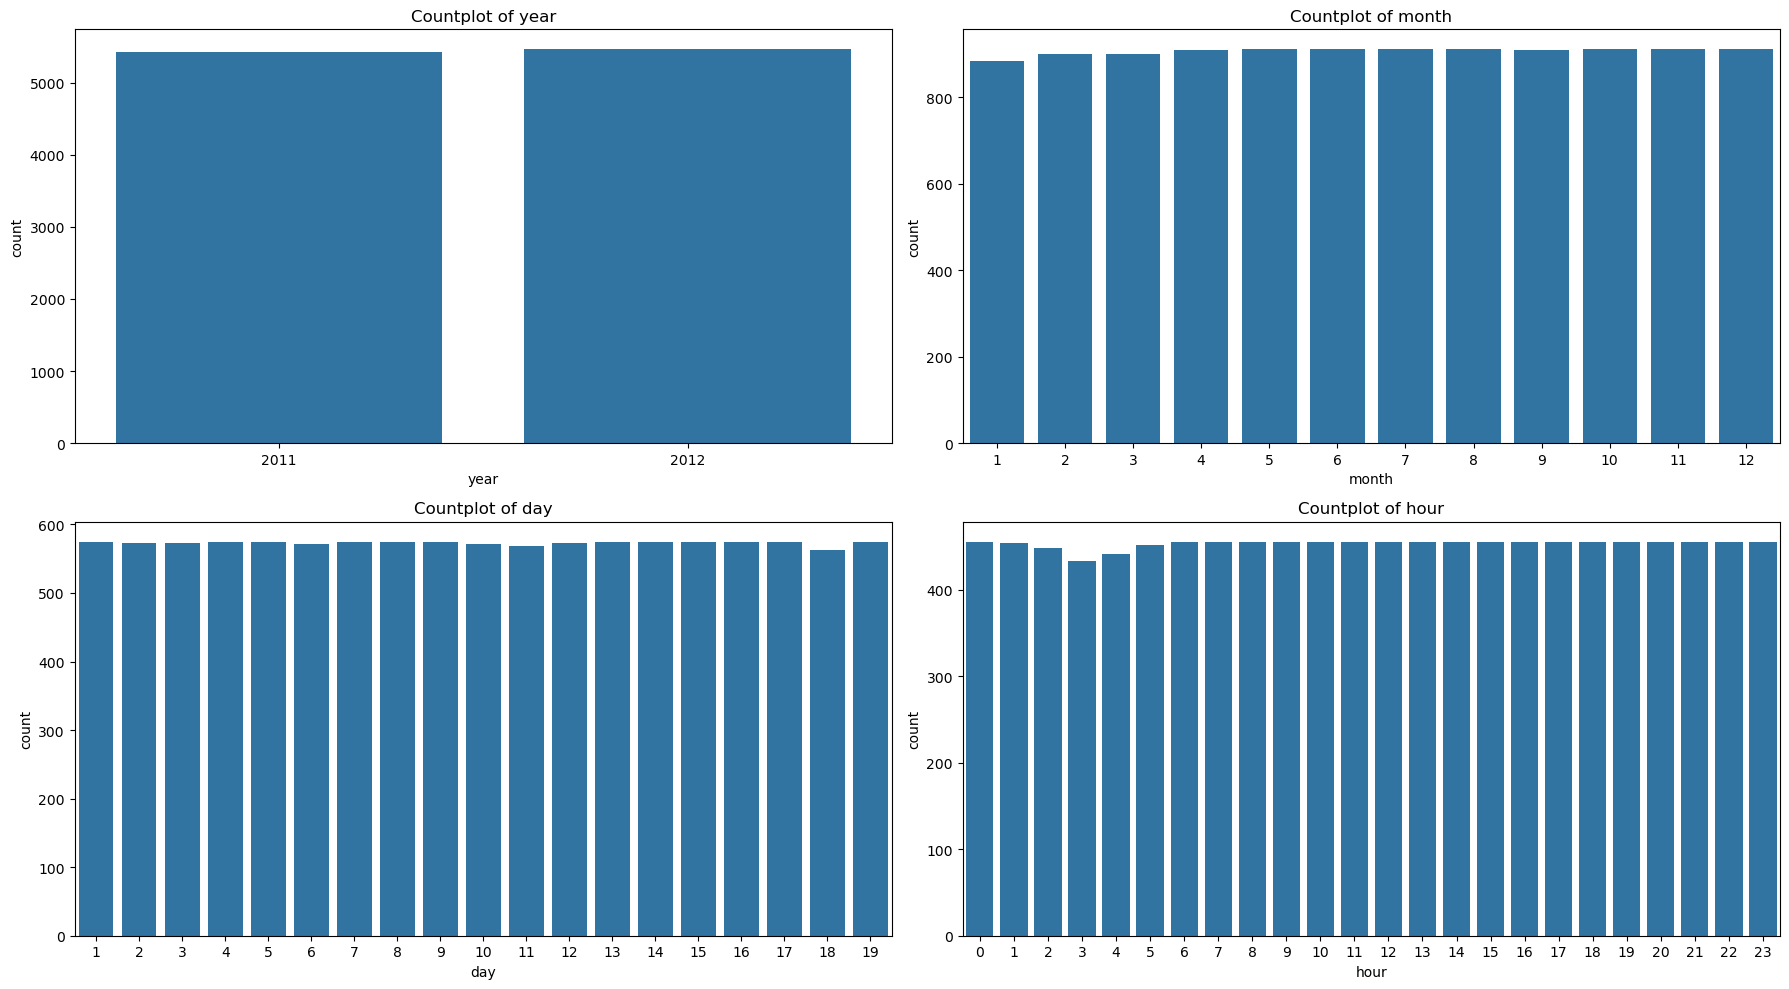

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(2, 2, figsize=(18, 10))
cols = ['year', 'month', 'day', 'hour']
for ax, col in zip(axs.flatten(), cols):
    sns.countplot(x=col, data=train, ax=ax)
    ax.set_title(f'Countplot of {col}')
plt.tight_layout()
plt.show()

In [7]:
# 시간을 출/퇴근 시간으로 나누어서 binning
def categorize_time(hour):
    if 7 <= hour <= 10:
        return 'morning rush'
    elif 16 <= hour <= 19:
        return 'evening rush'
    else:
        return 'etc'

# 1) time_bin 생성
train['time_bin'] = train['hour'].apply(categorize_time)

train.head()


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,time_bin
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,etc
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,etc
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,etc
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,etc
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,etc


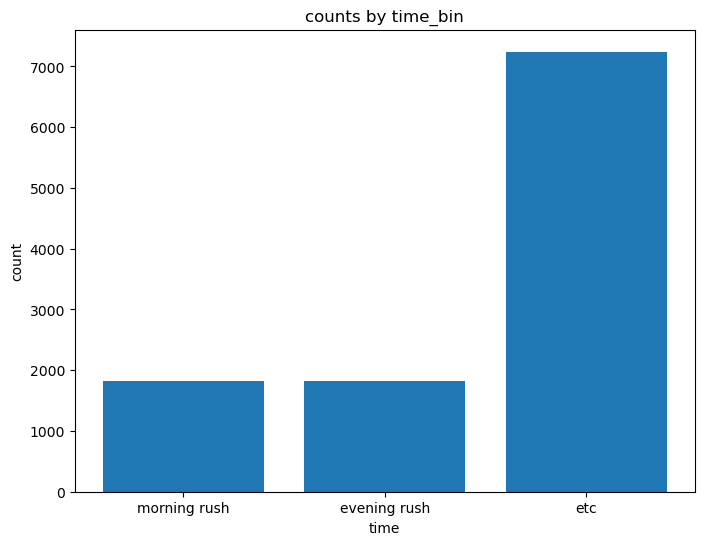

In [9]:
# 2) 각 카테고리별 개수 세기
counts = train['time_bin'].value_counts().reindex(['morning rush','evening rush','etc'], fill_value=0)

# 3) matplotlib으로 막대그래프 그리기
plt.figure(figsize=(8, 6))
plt.bar(counts.index, counts.values)
plt.xlabel('time')
plt.ylabel('count')
plt.title('counts by time_bin')
plt.show()

In [13]:
features = ['year', 'month', 'day', 'time_bin', 'temp', 'humidity' ]
X = train[features]
y = train['count']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# 1) time_bin 값 one-hot encoding
train_ohe = pd.get_dummies(train, columns=['time_bin'], drop_first=False)

In [17]:
from sklearn.linear_model import LinearRegression

# 2) 기존 수치형 피처 + time_bin 더미 컬럼 합치기
base_features = ['year','month','day','hour','temp','humidity','windspeed']
timebin_feats = [c for c in train_ohe.columns if c.startswith('time_bin_')]
features = base_features + timebin_feats

X = train_ohe[features]
y = train_ohe['count']

# 3) 학습/평가 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 4) 모델 학습
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [18]:
from sklearn.metrics import mean_squared_error
import numpy as np

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("MSE:", mse)
print("RMSE:", rmse)

MSE: 14840.821045763367
RMSE: 121.82290854253714


In [23]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

lr_model = LinearRegression()
rf_model = RandomForestRegressor(random_state = 42)
xgb_model = XGBRegressor(random_state = 42)
lgbm_model = LGBMRegressor(random_state = 42)

model_list = [lr_model, rf_model, xgb_model, lgbm_model]
for model in model_list:
    # 1) 학습
    model.fit(X_train, y_train)
    # 2) 예측
    y_pred = model.predict(X_test)
    # 3) 매번 mse, rmse 재계산
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    # 4) 출력
    print(f"{model.__class__.__name__} → MSE: {mse:.2f}, RMSE: {rmse:.2f}")

LinearRegression → MSE: 14840.82, RMSE: 121.82
RandomForestRegressor → MSE: 6605.43, RMSE: 81.27
XGBRegressor → MSE: 7057.32, RMSE: 84.01
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 8708, number of used features: 10
[LightGBM] [Info] Start training from score 191.584750
LGBMRegressor → MSE: 6859.79, RMSE: 82.82
